In [1]:
from a4_utils import *
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math
import random

def gauss(sigma):
    gauss_kernel = []
    for x in range(math.floor(- 3 * sigma), math.ceil(3 * sigma) + 1):
        result_x = (1 / (math.sqrt(2 * math.pi) * sigma)) * \
            math.exp(-((x ** 2) / (2 * (sigma ** 2))))
        gauss_kernel.append(result_x)
    return np.array(gauss_kernel) / sum(gauss_kernel)

def gaussdx(sigma):
    gaussdx_kernel = []
    for x in range(math.floor(- 3 * sigma), math.ceil(3 * sigma) + 1):
        result_x = (-1 / (math.sqrt(2 * math.pi) * sigma ** 3)) * x * math.exp(-(x ** 2 / (2 * sigma ** 2)))
        gaussdx_kernel.append(result_x)
    return np.array(gaussdx_kernel) / sum(np.abs(gaussdx_kernel))

def compute_derivative(img, sigma):
    G=gauss(sigma).reshape(1,-1)
    GT=G.T
    G=np.flip(G)
    GT=np.flip(GT)

    D=gaussdx(sigma).reshape(1,-1)
    DT=D.T
    D=np.flip(D)
    DT=np.flip(DT)

    img_Gt = cv2.filter2D(img, -1, D)
    deriv_x = cv2.filter2D(img_Gt, -1, GT)
    img_G = cv2.filter2D(img, -1, G)
    deriv_y = cv2.filter2D(img_G, -1, DT)
    return deriv_x, deriv_y

def gaussfilter(img, sigma):
    G = gauss(sigma)
    G = G.reshape(1, -1)
    convolved_img = cv2.filter2D(img, -1, G)
    convolved_img = cv2.filter2D(convolved_img, -1, G.T)
    return convolved_img


def nonmaxima_suppression(det,thresh,box_size):
    h,w=det.shape

    suppressed=np.zeros((h,w))

    for i in range(h):
        for j in range(w):
            if det[i,j]>thresh:
                box=det[i-box_size//2:i+box_size//2+1,j-box_size//2:j+box_size//2+1]
                if box.size>0:
                    max_val=np.max(box)
                else:
                    max_val=0
                if det[i,j] == max_val:
                    suppressed[i,j] = 1
    return suppressed

def hessian_points(I, sigma, threshold):
    Ix, Iy = compute_derivative(I, sigma)
    Ixx,Ixy = compute_derivative(Ix,sigma)
    Iyx,Iyy = compute_derivative(Iy,sigma)

    H=np.zeros((I.shape[0],I.shape[1],2,2))
    H[:,:,0,0]=Ixx
    H[:,:,0,1]=Ixy
    H[:,:,1,0]=Iyx
    H[:,:,1,1]=Iyy

    det= H[:,:,0,0]*H[:,:,1,1]-H[:,:,0,1]*H[:,:,1,0] 
    return det

def harris_points(I, sigma, threshold):
    sigma2 = 1.6 * sigma
    alpha = 0.06
    harris = np.zeros(I.shape)
    C = np.zeros((I.shape[0], I.shape[1], 2, 2))
    Ix,Iy=compute_derivative(I,sigma)

    C[:, :, 0, 0] = gaussfilter(Ix * Ix, sigma2)
    C[:, :, 0, 1] = gaussfilter(Ix * Iy, sigma2)
    C[:, :, 1, 0] = gaussfilter(Ix * Iy, sigma2)
    C[:, :, 1, 1] = gaussfilter(Iy * Iy, sigma2)

    det = C[:,:,0,0]*C[:,:,1,1]-C[:,:,0,1]*C[:,:,1,0]
    trace = C[:, :, 0, 0] + C[:, :, 1, 1]
    harris = det - alpha * trace * trace
    return harris

def find_correspondences(list1, list2):
    list_of_pairs=[]
    for i in range(len(list1)):
        descriptor1=list1[i]
        distances=np.zeros(len(list2))
        for j in range(len(list2)):
            descriptor2=list2[j]
            hellinger_distance=np.sqrt(np.sum((np.sqrt(descriptor1)-np.sqrt(descriptor2))**2))
            distances[j]=hellinger_distance
        
        most_similar=np.argmin(distances)
        list_of_pairs.append([i,most_similar])
    return list_of_pairs

def find_matches(I1, I2):
    harris_1 = harris_points(I1, 3, 0.0000001)
    harris_2 = harris_points(I2, 3, 0.0000001)

    suppressed_1 = nonmaxima_suppression(harris_1, 0.0000001, 3)
    suppressed_2 = nonmaxima_suppression(harris_2, 0.0000001, 3)

    x1=np.where(suppressed_1==1)[1]
    y1=np.where(suppressed_1==1)[0]

    x2=np.where(suppressed_2==1)[1]
    y2=np.where(suppressed_2==1)[0]

    list1 = simple_descriptors(I1, y1, x1)
    list2 = simple_descriptors(I2, y2, x2)

    pairs1 = find_correspondences(list1, list2)
    pairs2 = find_correspondences(list2, list1)

    pairs2 = [pair[::-1] for pair in pairs2]
    
    symmteric = []
    for pair in pairs1:
        if pair in pairs2:
            symmteric.append(pair)
    return symmteric

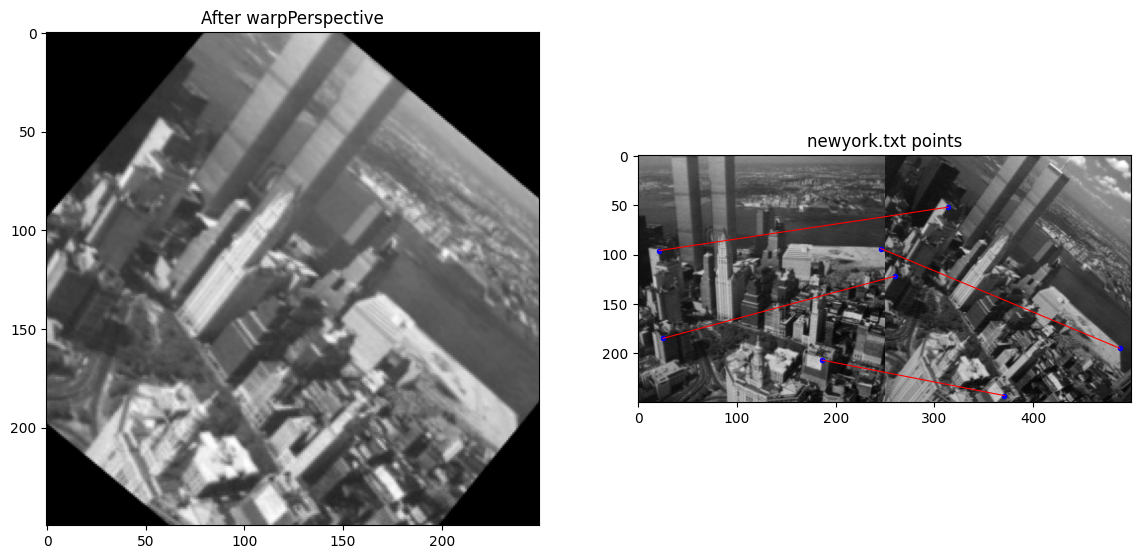

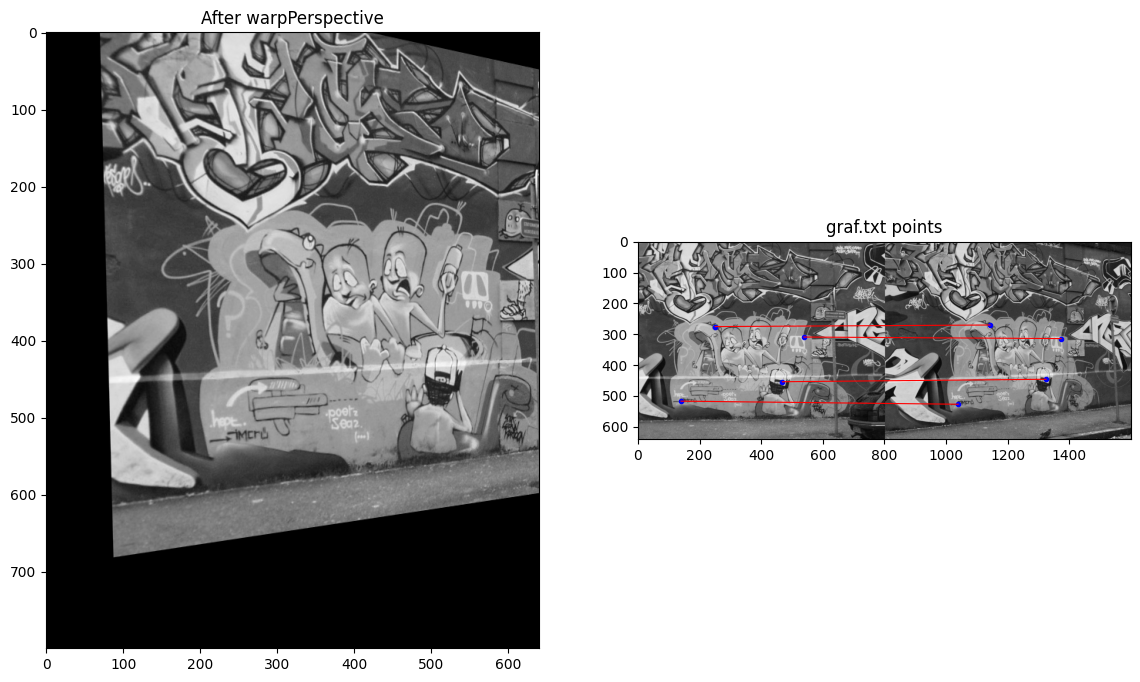

In [2]:
# (a)  Write function estimate_homography, that approximates a homography between 
# two images using a given set of matched feature points, following the algorithm below.

def estimate_homography(points1,points2):    
    A = np.zeros((2*len(points1),9))
    for i in range(len(points1)):
        x1,y1=points1[i]
        x2,y2=points2[i]
        A[2*i]=[x1,y1,1,0,0,0,-x2*x1,-x2*y1,-x2]
        A[2*i+1]=[0,0,0,x1,y1,1,-y2*x1,-y2*y1,-y2]

    U, S, V = np.linalg.svd(A)
    h = V[-1] / V[-1, -1]  
    H = h.reshape(3, 3)
    return H

def points_from_txt(path):
    data = np.loadtxt(path)
    x1 = data[:, 0]
    y1 = data[:, 1]
    x2 = data[:, 2]
    y2 = data[:, 3]

    points1 = []
    for i in range(len(x1)):
        points1.append([x1[i], y1[i]])

    points2 = []
    for i in range(len(x2)):
        points2.append([x2[i], y2[i]])
    return points1, points2

newyork_a_grayscale = cv2.imread("data/newyork/newyork_a.jpg", cv2.IMREAD_GRAYSCALE) / 255
newyork_b_grayscale = cv2.imread("data/newyork/newyork_b.jpg", cv2.IMREAD_GRAYSCALE) / 255

points1, points2 = points_from_txt("data/newyork/newyork.txt")

H = estimate_homography(points1, points2)
transformed_newyork_a = cv2.warpPerspective(newyork_a_grayscale, H, newyork_a_grayscale.shape)
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.imshow(transformed_newyork_a, cmap='gray')
plt.title("After warpPerspective")
plt.subplot(1,2,2)
plt.title("newyork.txt points")
display_matches(newyork_a_grayscale, points1, newyork_b_grayscale, points2)


graf_a_grayscale = cv2.imread("data/graf/graf_a.jpg", cv2.IMREAD_GRAYSCALE) / 255
graf_b_grayscale = cv2.imread("data/graf/graf_b.jpg", cv2.IMREAD_GRAYSCALE) / 255

points1_graf, points2_graf = points_from_txt("data/graf/graf.txt")

H_graf = estimate_homography(points1_graf, points2_graf)
transformed_graf_a = cv2.warpPerspective(graf_a_grayscale, H_graf, graf_a_grayscale.shape)
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.imshow(transformed_graf_a, cmap='gray')
plt.title("After warpPerspective")
plt.subplot(1,2,2)
plt.title("graf.txt points")
display_matches(graf_a_grayscale, points1_graf, graf_b_grayscale, points2_graf)

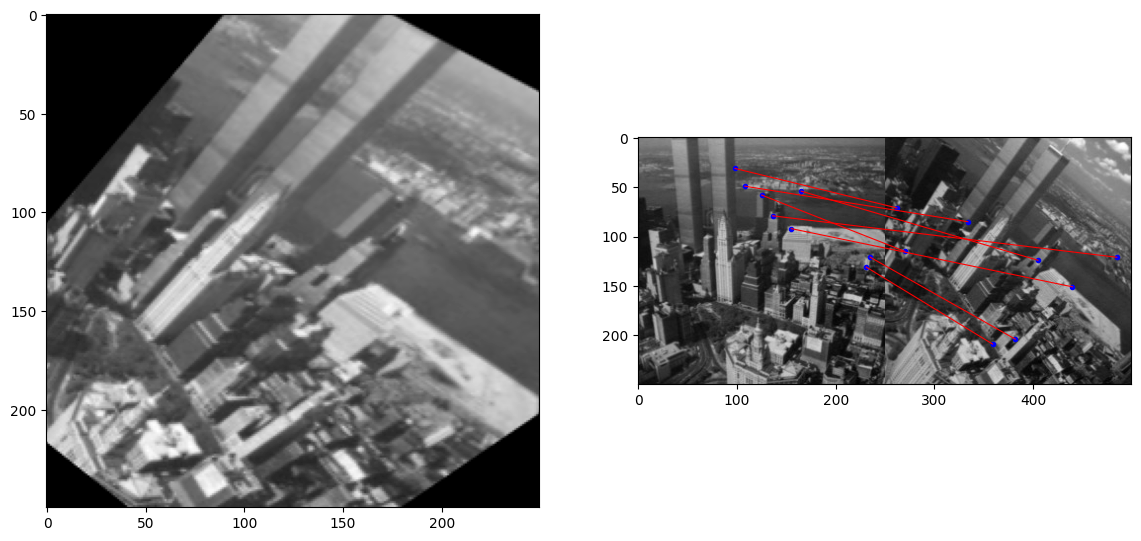

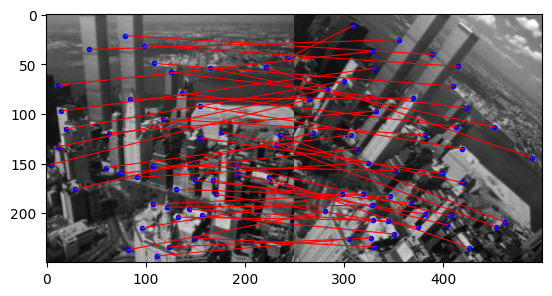

In [210]:
# (b) RANSAC

def ransac(matches, points1, points2):
    bestH = None
    bestInliers = None
    bestError = 10e10
    for i in range(5000):
        random_matches = random.sample(matches, 4)
        new_points_1 = []
        new_points_2 = []
        for a, b in random_matches:
            new_points_1.append(points1[a])
            new_points_2.append(points1[b])
        H = estimate_homography(new_points_1, new_points_2)
        inliers = []
        error = 0
        for a, b in matches:
            x1,y1=points1[a]
            x2,y2=points2[b]
            x1 = np.array([x1, y1, 1])
            x2 = np.array([x2, y2, 1])
            x1 = x1.reshape(3, 1)
            x2 = x2.reshape(3, 1)
            distance = np.linalg.norm(np.dot(H, x1) - x2)
            error += distance
            if distance < 10:
                inliers.append((a,b))
        if int(len(inliers)) != 0:
            error /= int(len(inliers))
        if error < bestError:
            bestInliers = inliers
            bestH = H
            bestError = error
        if len(inliers) > 4:
            new_points_11 = []
            new_points_22 = []
            for a, b in inliers:
                new_points_11.append(points1[a])
                new_points_22.append(points1[b])
            H1 = estimate_homography(new_points_11, new_points_22)
            inliers1 = []
            error1 = 0
            for a, b in matches:
                x1,y1=points1[a]
                x2,y2=points2[b]
                x1 = np.array([x1, y1, 1])
                x2 = np.array([x2, y2, 1])
                x1 = x1.reshape(3, 1)
                x2 = x2.reshape(3, 1)
                distance = np.linalg.norm(np.dot(H, x1) - x2)
                error1 += distance
                if distance < 10:
                    inliers1.append((a,b))
            if int(len(inliers1)) != 0:
                error1 /= int(len(inliers1))
            if error1 < bestError:
                bestInliers = inliers1
                bestH = H1
                bestError = error1
                
    return bestInliers, bestH

harris_a = harris_points(newyork_a_grayscale, 3, 0.0000001)
harris_b = harris_points(newyork_b_grayscale, 3, 0.0000001)

suppressed_a = nonmaxima_suppression(harris_a, 0.0000001, 3)
suppressed_b = nonmaxima_suppression(harris_b, 0.0000001, 3)

x1=np.where(suppressed_a==1)[1]
y1=np.where(suppressed_a==1)[0]

x2=np.where(suppressed_b==1)[1]
y2=np.where(suppressed_b==1)[0]

list1 = simple_descriptors(newyork_a_grayscale, y1, x1)
list2 = simple_descriptors(newyork_b_grayscale, y2, x2)

pairs = find_correspondences(list1, list2)

points1 = []
for i in range(len(x1)):
    points1.append([x1[i], y1[i]])

points2 = []
for i in range(len(x2)):
    points2.append([x2[i], y2[i]])

symmetric_pairs = find_matches(newyork_a_grayscale, newyork_b_grayscale)
most_similar_1 = []
most_similar_2 = []
for a,b in symmetric_pairs:
    most_similar_1.append(points1[a])
    most_similar_2.append(points2[b])

bestInliers, bestH = ransac(symmetric_pairs, points1, points2)
best_1 = []
best_2 = []
for a,b in bestInliers:
    best_1.append(points1[a])
    best_2.append(points1[b])
new_img = cv2.warpPerspective(newyork_a_grayscale, bestH, newyork_a_grayscale.shape)
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.imshow(new_img, cmap="gray")
plt.subplot(1,2,2)
display_matches(newyork_a_grayscale, best_1, newyork_b_grayscale, best_2)
display_matches(newyork_a_grayscale, most_similar_1, newyork_b_grayscale, most_similar_2)

